# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion).

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1]
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

In [ ]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

print(f"Device = {device}, dtype = {dtype}")

Device = cuda, dtype = torch.float32


### Dataset

In [ ]:
with h5py.File("TrafficFlow.h5", "r") as file:
    print(file.keys())
    # Coordinates
    t_mesh = torch.tensor(np.array(file["t_mesh"]), dtype=dtype).to(device)
    x_mesh = torch.tensor(np.array(file["x_mesh"]), dtype=dtype).to(device)
    # Training data
    a_train = torch.tensor(np.array(file["a_train"]), dtype=dtype).to(device)
    u_train = torch.tensor(np.array(file["u_train"]), dtype=dtype).to(device)
    # Testing data
    a_test = torch.tensor(np.array(file["a_test"]), dtype=dtype).to(device)
    u_test = torch.tensor(np.array(file["u_test"]), dtype=dtype).to(device)

# Get the number of training and testing samples and the grid resolution
ntrain = a_train.shape[0]
ntest = a_test.shape[0]
nx = x_mesh.shape[0]
nt = t_mesh.shape[0]

# Mesh grid for the coordinates
X, T = torch.meshgrid(x_mesh.squeeze(), t_mesh.squeeze(), indexing="ij")
grid = torch.stack([X, T], dim=-1).unsqueeze(0).repeat(ntrain, 1, 1, 1).to(device) # [ntrain, nx, nt, 2]

# Add dimensions for compatibility with FNO
a_train = a_train.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, nt, 1) # [ntrain, nx, nt, 1]
u_train = u_train.permute(0, 2, 1).unsqueeze(-1) # [ntrain, nx, nt, 1]

# Aggregate the values of (a(x), x, t) for TRAINING
ax_t_train = torch.cat([a_train, grid], dim=-1)                     # [ntrain, nx, nt, 3]

# For testing data
a_test = a_test.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, nt, 1) # [ntest, nx, nt, 1]
grid_test = torch.stack([X, T], dim=-1).unsqueeze(0).repeat(ntest, 1, 1, 1).to(device) # [ntest, nx, nt, 2]
u_test_plot =  u_test.permute(0, 2,1).unsqueeze(-1) # [ntest, nx, nt, 1]

ax_t_test = torch.cat([a_test, grid_test], dim=-1) # [ntest, nx, nt, 3]

print("\nTraining data...")
print("A_train shape:", a_train.shape)
print("U_train shape:", u_train.shape)
print("ax_t_train shape:", ax_t_train.shape)

print("\nTesting data...")
print("A_test shape:", a_test.shape)
print("U_test shape:", u_test_plot.shape)
print("ax_t_test shape:", ax_t_test.shape)

<KeysViewHDF5 ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']>

Training data...
A_train shape: torch.Size([1000, 128, 100, 1])
U_train shape: torch.Size([1000, 128, 100, 1])
ax_t_train shape: torch.Size([1000, 128, 100, 3])

Testing data...
A_test shape: torch.Size([200, 128, 100, 1])
U_test shape: torch.Size([200, 128, 100, 1])
ax_t_test shape: torch.Size([200, 128, 100, 3])


Neural Network Architecture (FNO)

In [ ]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    """Spectral convolution layer."""

    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()

        # Input and output size
        self.in_size = in_size
        self.out_size = out_size
        # Modes in x and y direction
        self.modes1 = modes1
        self.modes2 = modes2

        # Scale factor for initializing
        self.scale = 1. / (in_size * out_size)

        if (dtype is None) or (dtype == torch.float32):
            ctype = torch.complex64
        elif dtype == torch.float64:
            ctype = torch.complex128
        else:
            raise ValueError("Unsupported dtype. Use torch.float32 or torch.float64.")

        # Learnable weights for the Fourier modes
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))

    def compl_mul_2d(self, input, weights):
        """Complex multiplication of two tensors in the Fourier domain."""
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        """Forward pass through the spectral convolution layer."""
        # Store batch size
        batch_size = x.shape[0]

        # Fast Fourier Transform (FFT) of the input
        # x_ft: size(batch_size, in_size, height, width//2+1)
        x_ft = torch.fft.rfft2(x)

        # Create an output tensor for the Fourier domain result
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1) // 2 + 1,
                             device=x.device, dtype=torch.cfloat)
        # Multiply the low-frequency modes
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        # Multiply the high-frequency modes
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

        # Inverse Fast Fourier Transform (IFFT) to return to the spatial domain
        # x: size(batch_size, out_size, height, width)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        return x

class FNO2d(nn.Module):
    """2D Fourier Neural Operator."""

    def __init__(self, in_size, out_size, modes1, modes2, hidden_list, dtype=None):
        super(FNO2d, self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        # Modes in x and y direction
        self.modes1 = modes1
        self.modes2 = modes2
        # List of hidden layer sizes
        self.hidden_list = hidden_list

        # Activation function
        self.activation = nn.ReLU()

        # Input linear layer
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)

        # Spectral convolutional layers and 1x1 convolutional layers
        conv_net, w_net = [], []
        hidden_in = hidden_list[0]
        for hidden_out in hidden_list:
            conv_net.append(SpectralConv2d(hidden_in, hidden_out, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(hidden_in, hidden_out, 1, dtype=dtype))
            hidden_in = hidden_out
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)

        # Output layers
        self.fc_out0 = nn.Linear(hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)

    def forward(self, ax):
        """Forward pass through the FNO model."""
        batch_size = ax.shape[0]
        mx_size, my_size = ax.shape[1], ax.shape[2]

        # Input layer
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)

        # Spectral convolutional layers
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            ax1 = conv(ax)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1 + ax2)

        # Output layers
        ax = ax.permute(0, 2, 3, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        return self.fc_out1(ax)

mode1, mode2 = 8, 8
hidden_list = [40, 40, 40]
model_u = FNO2d(ax_t_train.shape[-1], u_train.shape[-1], mode1, mode2, hidden_list).to(device)

total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

624,857 training parameters.


### Loss and Error

In [ ]:
class LossClass(object):
    """Loss between predicted and true velocity fields."""

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def __call__(self, ax_batch, u_batch):
        batch_size = ax_batch.shape[0]
        ax, u = ax_batch.to(self.device), u_batch.to(self.device)

        u_pred = self.u_model(ax)
        loss = torch.norm(u.reshape(batch_size, -1) - u_pred.reshape(batch_size, -1), 2, 1)

        return torch.mean(loss)

class ErrorClass(object):
    """Relative L2 error between predicted and true velocity fields."""
    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def __call__(self, ax_batch, u_batch):
        ax, u = ax_batch.to(self.device), u_batch.to(self.device)
        u_pred = self.u_model(ax)

        return torch.norm(u - u_pred) / torch.norm(u)

# 4) DataSet Class

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    """Custom Dataset for traffic flow data."""

    def __init__(self, ax, u):
        self.ax = ax
        self.u = u

    def __len__(self):
        """Returns the total number of samples."""
        return self.ax.shape[0]

    def __getitem__(self, idx):
        """Returns sample at the given index."""
        ax = self.ax[idx]
        u = self.u[idx]
        return ax, u

# DataLoader for the train data
train_loader = DataLoader(MyDataset(ax_t_train, u_train), batch_size=50, shuffle=True)
for axt_batch, u_batch in train_loader:
    print("ax_t_batch shape:", axt_batch.shape, "u_batch shape:", u_batch.shape)
    break

# DataLoader for the test data
test_loader = DataLoader(MyDataset(ax_t_test, u_test_plot), batch_size=50, shuffle=False) # No need to shuffle test data
for axt_batch, u_batch in test_loader:
    print("ax_t_batch shape:", axt_batch.shape, "u_batch shape:", u_batch.shape)
    break

ax_t_batch shape: torch.Size([50, 128, 100, 3]) u_batch shape: torch.Size([50, 128, 100, 1])
ax_t_batch shape: torch.Size([50, 128, 100, 3]) u_batch shape: torch.Size([50, 128, 100, 1])


### Training

In [ ]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time

################# Training setups
epochs = 200
lr = 1e-3

optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs // 4, gamma=0.5)

loss_fn = LossClass(model_u)
error_fn = ErrorClass(model_u)

start_time = time.time()

loss_history, error_history = [], []
for epoch in trange(epochs):
    epoch_loss = 0.0
    epoch_error = 0.0
    for a_batch, u_batch in train_loader:
        loss = loss_fn(a_batch, u_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    epoch_loss /= len(train_loader)
    loss_history.append(epoch_loss)

    with torch.no_grad():
        error_total = 0
        for a_test_loader, u_test_loader in test_loader:
            error = error_fn(a_test_loader, u_test_loader)
            error_total += error
        epoch_error = error_total.item() / len(test_loader)
        error_history.append(epoch_error)


    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}, Error: {epoch_error:.6f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTraining complete. Total time elapsed: {total_time:.2f} seconds")

  0%|          | 1/200 [00:04<16:10,  4.87s/it]

Epoch 1/200, Loss: 20.305514, Error: 0.383957, Learning Rate: 0.001000


  1%|          | 2/200 [00:08<13:03,  3.96s/it]

Epoch 2/200, Loss: 6.734773, Error: 0.162635, Learning Rate: 0.001000


  2%|▏         | 3/200 [00:11<12:02,  3.67s/it]

Epoch 3/200, Loss: 3.093041, Error: 0.094510, Learning Rate: 0.001000


  2%|▏         | 4/200 [00:14<11:31,  3.53s/it]

Epoch 4/200, Loss: 2.013037, Error: 0.064879, Learning Rate: 0.001000


  2%|▎         | 5/200 [00:18<11:13,  3.45s/it]

Epoch 5/200, Loss: 1.506653, Error: 0.053509, Learning Rate: 0.001000


  3%|▎         | 6/200 [00:21<11:01,  3.41s/it]

Epoch 6/200, Loss: 1.256058, Error: 0.045666, Learning Rate: 0.001000


  4%|▎         | 7/200 [00:24<10:52,  3.38s/it]

Epoch 7/200, Loss: 1.084315, Error: 0.037530, Learning Rate: 0.001000


  4%|▍         | 8/200 [00:28<10:45,  3.36s/it]

Epoch 8/200, Loss: 0.958626, Error: 0.033091, Learning Rate: 0.001000


  4%|▍         | 9/200 [00:31<10:40,  3.35s/it]

Epoch 9/200, Loss: 0.885924, Error: 0.034410, Learning Rate: 0.001000


  5%|▌         | 10/200 [00:34<10:35,  3.35s/it]

Epoch 10/200, Loss: 0.821935, Error: 0.031907, Learning Rate: 0.001000


  6%|▌         | 11/200 [00:38<10:32,  3.34s/it]

Epoch 11/200, Loss: 0.789615, Error: 0.030839, Learning Rate: 0.001000


  6%|▌         | 12/200 [00:41<10:28,  3.34s/it]

Epoch 12/200, Loss: 0.748585, Error: 0.025915, Learning Rate: 0.001000


  6%|▋         | 13/200 [00:44<10:24,  3.34s/it]

Epoch 13/200, Loss: 0.712116, Error: 0.026639, Learning Rate: 0.001000


  7%|▋         | 14/200 [00:48<10:21,  3.34s/it]

Epoch 14/200, Loss: 0.685568, Error: 0.024763, Learning Rate: 0.001000


  8%|▊         | 15/200 [00:51<10:17,  3.34s/it]

Epoch 15/200, Loss: 0.655342, Error: 0.023715, Learning Rate: 0.001000


  8%|▊         | 16/200 [00:54<10:15,  3.35s/it]

Epoch 16/200, Loss: 0.651740, Error: 0.023194, Learning Rate: 0.001000


  8%|▊         | 17/200 [00:58<10:11,  3.34s/it]

Epoch 17/200, Loss: 0.619362, Error: 0.019942, Learning Rate: 0.001000


  9%|▉         | 18/200 [01:01<10:07,  3.34s/it]

Epoch 18/200, Loss: 0.619233, Error: 0.022712, Learning Rate: 0.001000


 10%|▉         | 19/200 [01:04<10:03,  3.34s/it]

Epoch 19/200, Loss: 0.599473, Error: 0.022127, Learning Rate: 0.001000


 10%|█         | 20/200 [01:08<10:00,  3.33s/it]

Epoch 20/200, Loss: 0.603725, Error: 0.024300, Learning Rate: 0.001000


 10%|█         | 21/200 [01:11<09:56,  3.33s/it]

Epoch 21/200, Loss: 0.609734, Error: 0.021315, Learning Rate: 0.001000


 11%|█         | 22/200 [01:14<09:52,  3.33s/it]

Epoch 22/200, Loss: 0.611391, Error: 0.024997, Learning Rate: 0.001000


 12%|█▏        | 23/200 [01:18<09:49,  3.33s/it]

Epoch 23/200, Loss: 0.575675, Error: 0.026875, Learning Rate: 0.001000


 12%|█▏        | 24/200 [01:21<09:45,  3.33s/it]

Epoch 24/200, Loss: 0.765637, Error: 0.024097, Learning Rate: 0.001000


 12%|█▎        | 25/200 [01:24<09:42,  3.33s/it]

Epoch 25/200, Loss: 0.593163, Error: 0.018084, Learning Rate: 0.001000


 13%|█▎        | 26/200 [01:28<09:38,  3.33s/it]

Epoch 26/200, Loss: 0.572115, Error: 0.019927, Learning Rate: 0.001000


 14%|█▎        | 27/200 [01:31<09:35,  3.33s/it]

Epoch 27/200, Loss: 0.578533, Error: 0.020684, Learning Rate: 0.001000


 14%|█▍        | 28/200 [01:34<09:31,  3.32s/it]

Epoch 28/200, Loss: 0.560404, Error: 0.018555, Learning Rate: 0.001000


 14%|█▍        | 29/200 [01:38<09:28,  3.32s/it]

Epoch 29/200, Loss: 0.552378, Error: 0.019710, Learning Rate: 0.001000


 15%|█▌        | 30/200 [01:41<09:24,  3.32s/it]

Epoch 30/200, Loss: 0.538352, Error: 0.018807, Learning Rate: 0.001000


 16%|█▌        | 31/200 [01:44<09:21,  3.32s/it]

Epoch 31/200, Loss: 0.524932, Error: 0.019073, Learning Rate: 0.001000


 16%|█▌        | 32/200 [01:48<09:18,  3.32s/it]

Epoch 32/200, Loss: 0.515281, Error: 0.016511, Learning Rate: 0.001000


 16%|█▋        | 33/200 [01:51<09:15,  3.32s/it]

Epoch 33/200, Loss: 0.517111, Error: 0.016406, Learning Rate: 0.001000


 17%|█▋        | 34/200 [01:54<09:11,  3.32s/it]

Epoch 34/200, Loss: 0.553111, Error: 0.020524, Learning Rate: 0.001000


 18%|█▊        | 35/200 [01:58<09:08,  3.33s/it]

Epoch 35/200, Loss: 0.511744, Error: 0.019031, Learning Rate: 0.001000


 18%|█▊        | 36/200 [02:01<09:05,  3.33s/it]

Epoch 36/200, Loss: 0.518074, Error: 0.018830, Learning Rate: 0.001000


 18%|█▊        | 37/200 [02:04<09:02,  3.33s/it]

Epoch 37/200, Loss: 0.613371, Error: 0.031415, Learning Rate: 0.001000


 19%|█▉        | 38/200 [02:08<08:59,  3.33s/it]

Epoch 38/200, Loss: 0.638791, Error: 0.021124, Learning Rate: 0.001000


 20%|█▉        | 39/200 [02:11<08:55,  3.33s/it]

Epoch 39/200, Loss: 0.564794, Error: 0.023197, Learning Rate: 0.001000


 20%|██        | 40/200 [02:14<08:52,  3.33s/it]

Epoch 40/200, Loss: 0.525630, Error: 0.018670, Learning Rate: 0.001000


 20%|██        | 41/200 [02:17<08:48,  3.33s/it]

Epoch 41/200, Loss: 0.500424, Error: 0.016284, Learning Rate: 0.001000


 21%|██        | 42/200 [02:21<08:46,  3.33s/it]

Epoch 42/200, Loss: 0.490555, Error: 0.019376, Learning Rate: 0.001000


 22%|██▏       | 43/200 [02:24<08:42,  3.33s/it]

Epoch 43/200, Loss: 0.477541, Error: 0.016393, Learning Rate: 0.001000


 22%|██▏       | 44/200 [02:27<08:39,  3.33s/it]

Epoch 44/200, Loss: 0.486626, Error: 0.016786, Learning Rate: 0.001000


 22%|██▎       | 45/200 [02:31<08:35,  3.33s/it]

Epoch 45/200, Loss: 0.490164, Error: 0.015923, Learning Rate: 0.001000


 23%|██▎       | 46/200 [02:34<08:32,  3.33s/it]

Epoch 46/200, Loss: 0.480726, Error: 0.020105, Learning Rate: 0.001000


 24%|██▎       | 47/200 [02:37<08:29,  3.33s/it]

Epoch 47/200, Loss: 0.507267, Error: 0.023229, Learning Rate: 0.001000


 24%|██▍       | 48/200 [02:41<08:25,  3.33s/it]

Epoch 48/200, Loss: 0.518751, Error: 0.014773, Learning Rate: 0.001000


 24%|██▍       | 49/200 [02:44<08:22,  3.33s/it]

Epoch 49/200, Loss: 0.504235, Error: 0.015702, Learning Rate: 0.001000


 25%|██▌       | 50/200 [02:47<08:19,  3.33s/it]

Epoch 50/200, Loss: 0.542524, Error: 0.023170, Learning Rate: 0.000500


 26%|██▌       | 51/200 [02:51<08:15,  3.33s/it]

Epoch 51/200, Loss: 0.410866, Error: 0.012372, Learning Rate: 0.000500


 26%|██▌       | 52/200 [02:54<08:12,  3.33s/it]

Epoch 52/200, Loss: 0.315852, Error: 0.011334, Learning Rate: 0.000500


 26%|██▋       | 53/200 [02:57<08:09,  3.33s/it]

Epoch 53/200, Loss: 0.298922, Error: 0.011138, Learning Rate: 0.000500


 27%|██▋       | 54/200 [03:01<08:05,  3.33s/it]

Epoch 54/200, Loss: 0.293233, Error: 0.011237, Learning Rate: 0.000500


 28%|██▊       | 55/200 [03:04<08:02,  3.33s/it]

Epoch 55/200, Loss: 0.296566, Error: 0.010950, Learning Rate: 0.000500


 28%|██▊       | 56/200 [03:07<07:58,  3.33s/it]

Epoch 56/200, Loss: 0.293267, Error: 0.011073, Learning Rate: 0.000500


 28%|██▊       | 57/200 [03:11<07:55,  3.33s/it]

Epoch 57/200, Loss: 0.291196, Error: 0.010670, Learning Rate: 0.000500


 29%|██▉       | 58/200 [03:14<07:52,  3.32s/it]

Epoch 58/200, Loss: 0.288690, Error: 0.010874, Learning Rate: 0.000500


 30%|██▉       | 59/200 [03:17<07:48,  3.32s/it]

Epoch 59/200, Loss: 0.293181, Error: 0.010391, Learning Rate: 0.000500


 30%|███       | 60/200 [03:21<07:45,  3.33s/it]

Epoch 60/200, Loss: 0.296672, Error: 0.011191, Learning Rate: 0.000500


 30%|███       | 61/200 [03:24<07:42,  3.33s/it]

Epoch 61/200, Loss: 0.291154, Error: 0.011370, Learning Rate: 0.000500


 31%|███       | 62/200 [03:27<07:38,  3.32s/it]

Epoch 62/200, Loss: 0.299278, Error: 0.010263, Learning Rate: 0.000500


 32%|███▏      | 63/200 [03:31<07:35,  3.33s/it]

Epoch 63/200, Loss: 0.294750, Error: 0.010880, Learning Rate: 0.000500


 32%|███▏      | 64/200 [03:34<07:32,  3.33s/it]

Epoch 64/200, Loss: 0.301586, Error: 0.010207, Learning Rate: 0.000500


 32%|███▎      | 65/200 [03:37<07:28,  3.33s/it]

Epoch 65/200, Loss: 0.305150, Error: 0.011823, Learning Rate: 0.000500


 33%|███▎      | 66/200 [03:41<07:25,  3.32s/it]

Epoch 66/200, Loss: 0.310240, Error: 0.011064, Learning Rate: 0.000500


 34%|███▎      | 67/200 [03:44<07:22,  3.33s/it]

Epoch 67/200, Loss: 0.301376, Error: 0.011474, Learning Rate: 0.000500


 34%|███▍      | 68/200 [03:47<07:18,  3.33s/it]

Epoch 68/200, Loss: 0.298051, Error: 0.010757, Learning Rate: 0.000500


 34%|███▍      | 69/200 [03:51<07:15,  3.33s/it]

Epoch 69/200, Loss: 0.302305, Error: 0.010108, Learning Rate: 0.000500


 35%|███▌      | 70/200 [03:54<07:12,  3.33s/it]

Epoch 70/200, Loss: 0.291677, Error: 0.010626, Learning Rate: 0.000500


 36%|███▌      | 71/200 [03:57<07:09,  3.33s/it]

Epoch 71/200, Loss: 0.302957, Error: 0.010780, Learning Rate: 0.000500


 36%|███▌      | 72/200 [04:01<07:05,  3.33s/it]

Epoch 72/200, Loss: 0.323654, Error: 0.012060, Learning Rate: 0.000500


 36%|███▋      | 73/200 [04:04<07:02,  3.33s/it]

Epoch 73/200, Loss: 0.309751, Error: 0.010837, Learning Rate: 0.000500


 37%|███▋      | 74/200 [04:07<06:59,  3.33s/it]

Epoch 74/200, Loss: 0.297862, Error: 0.011112, Learning Rate: 0.000500


 38%|███▊      | 75/200 [04:11<06:55,  3.33s/it]

Epoch 75/200, Loss: 0.307638, Error: 0.010267, Learning Rate: 0.000500


 38%|███▊      | 76/200 [04:14<06:52,  3.33s/it]

Epoch 76/200, Loss: 0.301815, Error: 0.009994, Learning Rate: 0.000500


 38%|███▊      | 77/200 [04:17<06:49,  3.33s/it]

Epoch 77/200, Loss: 0.293567, Error: 0.010110, Learning Rate: 0.000500


 39%|███▉      | 78/200 [04:21<06:45,  3.33s/it]

Epoch 78/200, Loss: 0.303750, Error: 0.010078, Learning Rate: 0.000500


 40%|███▉      | 79/200 [04:24<06:42,  3.33s/it]

Epoch 79/200, Loss: 0.302290, Error: 0.011674, Learning Rate: 0.000500


 40%|████      | 80/200 [04:27<06:39,  3.33s/it]

Epoch 80/200, Loss: 0.305023, Error: 0.011052, Learning Rate: 0.000500


 40%|████      | 81/200 [04:31<06:35,  3.33s/it]

Epoch 81/200, Loss: 0.294940, Error: 0.011606, Learning Rate: 0.000500


 41%|████      | 82/200 [04:34<06:32,  3.33s/it]

Epoch 82/200, Loss: 0.310816, Error: 0.010618, Learning Rate: 0.000500


 42%|████▏     | 83/200 [04:37<06:29,  3.33s/it]

Epoch 83/200, Loss: 0.309074, Error: 0.009675, Learning Rate: 0.000500


 42%|████▏     | 84/200 [04:41<06:25,  3.33s/it]

Epoch 84/200, Loss: 0.310669, Error: 0.010742, Learning Rate: 0.000500


 42%|████▎     | 85/200 [04:44<06:22,  3.33s/it]

Epoch 85/200, Loss: 0.304262, Error: 0.010533, Learning Rate: 0.000500


 43%|████▎     | 86/200 [04:47<06:19,  3.33s/it]

Epoch 86/200, Loss: 0.300346, Error: 0.011170, Learning Rate: 0.000500


 44%|████▎     | 87/200 [04:50<06:15,  3.33s/it]

Epoch 87/200, Loss: 0.298103, Error: 0.010309, Learning Rate: 0.000500


 44%|████▍     | 88/200 [04:54<06:12,  3.33s/it]

Epoch 88/200, Loss: 0.308073, Error: 0.014996, Learning Rate: 0.000500


 44%|████▍     | 89/200 [04:57<06:09,  3.33s/it]

Epoch 89/200, Loss: 0.385189, Error: 0.013463, Learning Rate: 0.000500


 45%|████▌     | 90/200 [05:00<06:05,  3.33s/it]

Epoch 90/200, Loss: 0.349343, Error: 0.013285, Learning Rate: 0.000500


 46%|████▌     | 91/200 [05:04<06:02,  3.33s/it]

Epoch 91/200, Loss: 0.335798, Error: 0.013253, Learning Rate: 0.000500


 46%|████▌     | 92/200 [05:07<05:59,  3.33s/it]

Epoch 92/200, Loss: 0.353842, Error: 0.011109, Learning Rate: 0.000500


 46%|████▋     | 93/200 [05:10<05:56,  3.33s/it]

Epoch 93/200, Loss: 0.304686, Error: 0.011233, Learning Rate: 0.000500


 47%|████▋     | 94/200 [05:14<05:52,  3.33s/it]

Epoch 94/200, Loss: 0.304063, Error: 0.009633, Learning Rate: 0.000500


 48%|████▊     | 95/200 [05:17<05:49,  3.33s/it]

Epoch 95/200, Loss: 0.298821, Error: 0.011110, Learning Rate: 0.000500


 48%|████▊     | 96/200 [05:20<05:46,  3.33s/it]

Epoch 96/200, Loss: 0.293609, Error: 0.011898, Learning Rate: 0.000500


 48%|████▊     | 97/200 [05:24<05:42,  3.33s/it]

Epoch 97/200, Loss: 0.296714, Error: 0.010416, Learning Rate: 0.000500


 49%|████▉     | 98/200 [05:27<05:39,  3.33s/it]

Epoch 98/200, Loss: 0.295685, Error: 0.009974, Learning Rate: 0.000500


 50%|████▉     | 99/200 [05:30<05:35,  3.33s/it]

Epoch 99/200, Loss: 0.293624, Error: 0.010828, Learning Rate: 0.000500


 50%|█████     | 100/200 [05:34<05:32,  3.33s/it]

Epoch 100/200, Loss: 0.285140, Error: 0.010817, Learning Rate: 0.000250


 50%|█████     | 101/200 [05:37<05:29,  3.33s/it]

Epoch 101/200, Loss: 0.258596, Error: 0.008844, Learning Rate: 0.000250


 51%|█████     | 102/200 [05:40<05:25,  3.33s/it]

Epoch 102/200, Loss: 0.234160, Error: 0.008387, Learning Rate: 0.000250


 52%|█████▏    | 103/200 [05:44<05:22,  3.33s/it]

Epoch 103/200, Loss: 0.227073, Error: 0.008334, Learning Rate: 0.000250


 52%|█████▏    | 104/200 [05:47<05:19,  3.33s/it]

Epoch 104/200, Loss: 0.225611, Error: 0.008311, Learning Rate: 0.000250


 52%|█████▎    | 105/200 [05:50<05:15,  3.33s/it]

Epoch 105/200, Loss: 0.223984, Error: 0.008200, Learning Rate: 0.000250


 53%|█████▎    | 106/200 [05:54<05:13,  3.33s/it]

Epoch 106/200, Loss: 0.222960, Error: 0.008207, Learning Rate: 0.000250


 54%|█████▎    | 107/200 [05:57<05:10,  3.34s/it]

Epoch 107/200, Loss: 0.222536, Error: 0.008183, Learning Rate: 0.000250


 54%|█████▍    | 108/200 [06:00<05:08,  3.36s/it]

Epoch 108/200, Loss: 0.222361, Error: 0.008145, Learning Rate: 0.000250


 55%|█████▍    | 109/200 [06:04<05:05,  3.36s/it]

Epoch 109/200, Loss: 0.221260, Error: 0.008088, Learning Rate: 0.000250


 55%|█████▌    | 110/200 [06:07<05:01,  3.35s/it]

Epoch 110/200, Loss: 0.220681, Error: 0.008111, Learning Rate: 0.000250


 56%|█████▌    | 111/200 [06:11<04:57,  3.35s/it]

Epoch 111/200, Loss: 0.221862, Error: 0.008123, Learning Rate: 0.000250


 56%|█████▌    | 112/200 [06:14<04:54,  3.34s/it]

Epoch 112/200, Loss: 0.221346, Error: 0.007979, Learning Rate: 0.000250


 56%|█████▋    | 113/200 [06:17<04:50,  3.34s/it]

Epoch 113/200, Loss: 0.218853, Error: 0.008049, Learning Rate: 0.000250


 57%|█████▋    | 114/200 [06:21<04:47,  3.34s/it]

Epoch 114/200, Loss: 0.218044, Error: 0.007961, Learning Rate: 0.000250


 57%|█████▊    | 115/200 [06:24<04:44,  3.34s/it]

Epoch 115/200, Loss: 0.217390, Error: 0.007954, Learning Rate: 0.000250


 58%|█████▊    | 116/200 [06:27<04:40,  3.34s/it]

Epoch 116/200, Loss: 0.219862, Error: 0.007977, Learning Rate: 0.000250


 58%|█████▊    | 117/200 [06:31<04:36,  3.33s/it]

Epoch 117/200, Loss: 0.221987, Error: 0.008026, Learning Rate: 0.000250


 59%|█████▉    | 118/200 [06:34<04:33,  3.34s/it]

Epoch 118/200, Loss: 0.216543, Error: 0.007820, Learning Rate: 0.000250


 60%|█████▉    | 119/200 [06:37<04:30,  3.33s/it]

Epoch 119/200, Loss: 0.215012, Error: 0.007834, Learning Rate: 0.000250


 60%|██████    | 120/200 [06:41<04:26,  3.33s/it]

Epoch 120/200, Loss: 0.215959, Error: 0.007840, Learning Rate: 0.000250


 60%|██████    | 121/200 [06:44<04:23,  3.33s/it]

Epoch 121/200, Loss: 0.215236, Error: 0.007827, Learning Rate: 0.000250


 61%|██████    | 122/200 [06:47<04:20,  3.33s/it]

Epoch 122/200, Loss: 0.216630, Error: 0.007786, Learning Rate: 0.000250


 62%|██████▏   | 123/200 [06:51<04:16,  3.33s/it]

Epoch 123/200, Loss: 0.215500, Error: 0.007759, Learning Rate: 0.000250


 62%|██████▏   | 124/200 [06:54<04:13,  3.33s/it]

Epoch 124/200, Loss: 0.213236, Error: 0.007705, Learning Rate: 0.000250


 62%|██████▎   | 125/200 [06:57<04:10,  3.34s/it]

Epoch 125/200, Loss: 0.213519, Error: 0.007751, Learning Rate: 0.000250


 63%|██████▎   | 126/200 [07:01<04:07,  3.35s/it]

Epoch 126/200, Loss: 0.217847, Error: 0.007903, Learning Rate: 0.000250


 64%|██████▎   | 127/200 [07:04<04:04,  3.35s/it]

Epoch 127/200, Loss: 0.217308, Error: 0.007902, Learning Rate: 0.000250


 64%|██████▍   | 128/200 [07:07<04:00,  3.35s/it]

Epoch 128/200, Loss: 0.217705, Error: 0.008091, Learning Rate: 0.000250


 64%|██████▍   | 129/200 [07:11<03:57,  3.35s/it]

Epoch 129/200, Loss: 0.225244, Error: 0.008992, Learning Rate: 0.000250


 65%|██████▌   | 130/200 [07:14<03:53,  3.34s/it]

Epoch 130/200, Loss: 0.225267, Error: 0.007945, Learning Rate: 0.000250


 66%|██████▌   | 131/200 [07:17<03:50,  3.33s/it]

Epoch 131/200, Loss: 0.218414, Error: 0.008199, Learning Rate: 0.000250


 66%|██████▌   | 132/200 [07:21<03:46,  3.33s/it]

Epoch 132/200, Loss: 0.215086, Error: 0.007701, Learning Rate: 0.000250


 66%|██████▋   | 133/200 [07:24<03:43,  3.33s/it]

Epoch 133/200, Loss: 0.222546, Error: 0.007674, Learning Rate: 0.000250


 67%|██████▋   | 134/200 [07:27<03:39,  3.33s/it]

Epoch 134/200, Loss: 0.219743, Error: 0.008295, Learning Rate: 0.000250


 68%|██████▊   | 135/200 [07:31<03:36,  3.33s/it]

Epoch 135/200, Loss: 0.216782, Error: 0.007680, Learning Rate: 0.000250


 68%|██████▊   | 136/200 [07:34<03:34,  3.35s/it]

Epoch 136/200, Loss: 0.220235, Error: 0.007788, Learning Rate: 0.000250


 68%|██████▊   | 137/200 [07:37<03:31,  3.35s/it]

Epoch 137/200, Loss: 0.219538, Error: 0.007559, Learning Rate: 0.000250


 69%|██████▉   | 138/200 [07:41<03:27,  3.34s/it]

Epoch 138/200, Loss: 0.221230, Error: 0.007819, Learning Rate: 0.000250


 70%|██████▉   | 139/200 [07:44<03:23,  3.34s/it]

Epoch 139/200, Loss: 0.220111, Error: 0.007913, Learning Rate: 0.000250


 70%|███████   | 140/200 [07:47<03:20,  3.34s/it]

Epoch 140/200, Loss: 0.220987, Error: 0.008238, Learning Rate: 0.000250


 70%|███████   | 141/200 [07:51<03:17,  3.34s/it]

Epoch 141/200, Loss: 0.216481, Error: 0.007728, Learning Rate: 0.000250


 71%|███████   | 142/200 [07:54<03:13,  3.34s/it]

Epoch 142/200, Loss: 0.221205, Error: 0.008077, Learning Rate: 0.000250


 72%|███████▏  | 143/200 [07:57<03:10,  3.34s/it]

Epoch 143/200, Loss: 0.218932, Error: 0.008498, Learning Rate: 0.000250


 72%|███████▏  | 144/200 [08:01<03:06,  3.34s/it]

Epoch 144/200, Loss: 0.218194, Error: 0.008542, Learning Rate: 0.000250


 72%|███████▎  | 145/200 [08:04<03:03,  3.34s/it]

Epoch 145/200, Loss: 0.222217, Error: 0.007981, Learning Rate: 0.000250


 73%|███████▎  | 146/200 [08:07<03:00,  3.34s/it]

Epoch 146/200, Loss: 0.217953, Error: 0.008040, Learning Rate: 0.000250


 74%|███████▎  | 147/200 [08:11<02:56,  3.34s/it]

Epoch 147/200, Loss: 0.219468, Error: 0.007669, Learning Rate: 0.000250


 74%|███████▍  | 148/200 [08:14<02:53,  3.34s/it]

Epoch 148/200, Loss: 0.217329, Error: 0.008231, Learning Rate: 0.000250


 74%|███████▍  | 149/200 [08:17<02:49,  3.33s/it]

Epoch 149/200, Loss: 0.224009, Error: 0.008009, Learning Rate: 0.000250


 75%|███████▌  | 150/200 [08:21<02:46,  3.33s/it]

Epoch 150/200, Loss: 0.218601, Error: 0.008037, Learning Rate: 0.000125


 76%|███████▌  | 151/200 [08:24<02:43,  3.33s/it]

Epoch 151/200, Loss: 0.204651, Error: 0.007230, Learning Rate: 0.000125


 76%|███████▌  | 152/200 [08:27<02:39,  3.33s/it]

Epoch 152/200, Loss: 0.197616, Error: 0.007224, Learning Rate: 0.000125


 76%|███████▋  | 153/200 [08:31<02:36,  3.33s/it]

Epoch 153/200, Loss: 0.195914, Error: 0.007191, Learning Rate: 0.000125


 77%|███████▋  | 154/200 [08:34<02:33,  3.33s/it]

Epoch 154/200, Loss: 0.195353, Error: 0.007159, Learning Rate: 0.000125


 78%|███████▊  | 155/200 [08:37<02:29,  3.33s/it]

Epoch 155/200, Loss: 0.195395, Error: 0.007217, Learning Rate: 0.000125


 78%|███████▊  | 156/200 [08:41<02:26,  3.33s/it]

Epoch 156/200, Loss: 0.195547, Error: 0.007151, Learning Rate: 0.000125


 78%|███████▊  | 157/200 [08:44<02:23,  3.33s/it]

Epoch 157/200, Loss: 0.195096, Error: 0.007183, Learning Rate: 0.000125


 79%|███████▉  | 158/200 [08:47<02:20,  3.34s/it]

Epoch 158/200, Loss: 0.193993, Error: 0.007081, Learning Rate: 0.000125


 80%|███████▉  | 159/200 [08:51<02:16,  3.33s/it]

Epoch 159/200, Loss: 0.193553, Error: 0.007096, Learning Rate: 0.000125


 80%|████████  | 160/200 [08:54<02:13,  3.33s/it]

Epoch 160/200, Loss: 0.193648, Error: 0.007070, Learning Rate: 0.000125


 80%|████████  | 161/200 [08:57<02:10,  3.34s/it]

Epoch 161/200, Loss: 0.193116, Error: 0.007120, Learning Rate: 0.000125


 81%|████████  | 162/200 [09:01<02:06,  3.33s/it]

Epoch 162/200, Loss: 0.193611, Error: 0.007068, Learning Rate: 0.000125


 82%|████████▏ | 163/200 [09:04<02:03,  3.33s/it]

Epoch 163/200, Loss: 0.193743, Error: 0.007017, Learning Rate: 0.000125


 82%|████████▏ | 164/200 [09:07<01:59,  3.33s/it]

Epoch 164/200, Loss: 0.192711, Error: 0.007035, Learning Rate: 0.000125


 82%|████████▎ | 165/200 [09:11<01:56,  3.33s/it]

Epoch 165/200, Loss: 0.192360, Error: 0.007036, Learning Rate: 0.000125


 83%|████████▎ | 166/200 [09:14<01:53,  3.33s/it]

Epoch 166/200, Loss: 0.191820, Error: 0.007032, Learning Rate: 0.000125


 84%|████████▎ | 167/200 [09:17<01:49,  3.33s/it]

Epoch 167/200, Loss: 0.191202, Error: 0.006998, Learning Rate: 0.000125


 84%|████████▍ | 168/200 [09:21<01:46,  3.33s/it]

Epoch 168/200, Loss: 0.191517, Error: 0.006976, Learning Rate: 0.000125


 84%|████████▍ | 169/200 [09:24<01:43,  3.33s/it]

Epoch 169/200, Loss: 0.191013, Error: 0.006969, Learning Rate: 0.000125


 85%|████████▌ | 170/200 [09:27<01:39,  3.33s/it]

Epoch 170/200, Loss: 0.190988, Error: 0.006992, Learning Rate: 0.000125


 86%|████████▌ | 171/200 [09:31<01:36,  3.33s/it]

Epoch 171/200, Loss: 0.190547, Error: 0.006978, Learning Rate: 0.000125


 86%|████████▌ | 172/200 [09:34<01:33,  3.33s/it]

Epoch 172/200, Loss: 0.190625, Error: 0.006939, Learning Rate: 0.000125


 86%|████████▋ | 173/200 [09:37<01:30,  3.34s/it]

Epoch 173/200, Loss: 0.189575, Error: 0.006967, Learning Rate: 0.000125


 87%|████████▋ | 174/200 [09:41<01:27,  3.35s/it]

Epoch 174/200, Loss: 0.190923, Error: 0.006995, Learning Rate: 0.000125


 88%|████████▊ | 175/200 [09:44<01:24,  3.37s/it]

Epoch 175/200, Loss: 0.189709, Error: 0.006943, Learning Rate: 0.000125


 88%|████████▊ | 176/200 [09:47<01:20,  3.37s/it]

Epoch 176/200, Loss: 0.189852, Error: 0.006914, Learning Rate: 0.000125


 88%|████████▊ | 177/200 [09:51<01:17,  3.38s/it]

Epoch 177/200, Loss: 0.189841, Error: 0.006961, Learning Rate: 0.000125


 89%|████████▉ | 178/200 [09:54<01:14,  3.38s/it]

Epoch 178/200, Loss: 0.188714, Error: 0.006901, Learning Rate: 0.000125


 90%|████████▉ | 179/200 [09:58<01:10,  3.37s/it]

Epoch 179/200, Loss: 0.188294, Error: 0.006866, Learning Rate: 0.000125


 90%|█████████ | 180/200 [10:01<01:07,  3.38s/it]

Epoch 180/200, Loss: 0.189552, Error: 0.006936, Learning Rate: 0.000125


 90%|█████████ | 181/200 [10:04<01:03,  3.36s/it]

Epoch 181/200, Loss: 0.187987, Error: 0.006842, Learning Rate: 0.000125


 91%|█████████ | 182/200 [10:08<01:00,  3.35s/it]

Epoch 182/200, Loss: 0.188060, Error: 0.006892, Learning Rate: 0.000125


 92%|█████████▏| 183/200 [10:11<00:56,  3.35s/it]

Epoch 183/200, Loss: 0.188102, Error: 0.006840, Learning Rate: 0.000125


 92%|█████████▏| 184/200 [10:14<00:53,  3.34s/it]

Epoch 184/200, Loss: 0.187177, Error: 0.006897, Learning Rate: 0.000125


 92%|█████████▎| 185/200 [10:18<00:50,  3.34s/it]

Epoch 185/200, Loss: 0.187060, Error: 0.006840, Learning Rate: 0.000125


 93%|█████████▎| 186/200 [10:21<00:46,  3.33s/it]

Epoch 186/200, Loss: 0.186556, Error: 0.006837, Learning Rate: 0.000125


 94%|█████████▎| 187/200 [10:24<00:43,  3.33s/it]

Epoch 187/200, Loss: 0.188118, Error: 0.006860, Learning Rate: 0.000125


 94%|█████████▍| 188/200 [10:28<00:39,  3.33s/it]

Epoch 188/200, Loss: 0.190055, Error: 0.006810, Learning Rate: 0.000125


 94%|█████████▍| 189/200 [10:31<00:36,  3.33s/it]

Epoch 189/200, Loss: 0.187160, Error: 0.006793, Learning Rate: 0.000125


 95%|█████████▌| 190/200 [10:34<00:33,  3.34s/it]

Epoch 190/200, Loss: 0.185885, Error: 0.006795, Learning Rate: 0.000125


 96%|█████████▌| 191/200 [10:38<00:30,  3.34s/it]

Epoch 191/200, Loss: 0.186440, Error: 0.006823, Learning Rate: 0.000125


 96%|█████████▌| 192/200 [10:41<00:26,  3.35s/it]

Epoch 192/200, Loss: 0.185381, Error: 0.006829, Learning Rate: 0.000125


 96%|█████████▋| 193/200 [10:44<00:23,  3.36s/it]

Epoch 193/200, Loss: 0.185607, Error: 0.006792, Learning Rate: 0.000125


 97%|█████████▋| 194/200 [10:48<00:20,  3.38s/it]

Epoch 194/200, Loss: 0.186488, Error: 0.006822, Learning Rate: 0.000125


 98%|█████████▊| 195/200 [10:51<00:16,  3.37s/it]

Epoch 195/200, Loss: 0.185209, Error: 0.006723, Learning Rate: 0.000125


 98%|█████████▊| 196/200 [10:55<00:13,  3.37s/it]

Epoch 196/200, Loss: 0.187508, Error: 0.006802, Learning Rate: 0.000125


 98%|█████████▊| 197/200 [10:58<00:10,  3.37s/it]

Epoch 197/200, Loss: 0.186667, Error: 0.006850, Learning Rate: 0.000125


 99%|█████████▉| 198/200 [11:01<00:06,  3.37s/it]

Epoch 198/200, Loss: 0.185875, Error: 0.006794, Learning Rate: 0.000125


100%|█████████▉| 199/200 [11:05<00:03,  3.37s/it]

Epoch 199/200, Loss: 0.186274, Error: 0.006674, Learning Rate: 0.000125


100%|██████████| 200/200 [11:08<00:00,  3.34s/it]

Epoch 200/200, Loss: 0.185789, Error: 0.007031, Learning Rate: 0.000063

Training complete. Total time elapsed: 668.50 seconds


### Plotting

torch.Size([1, 128, 100, 3])
torch.Size([128, 100])
torch.Size([128, 100])
L2 Relative Error for the first test sample: 0.010676


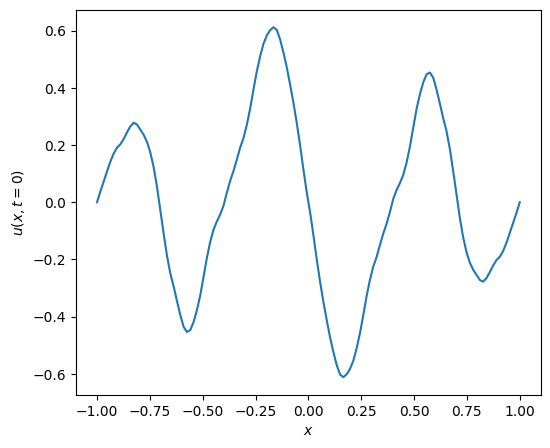

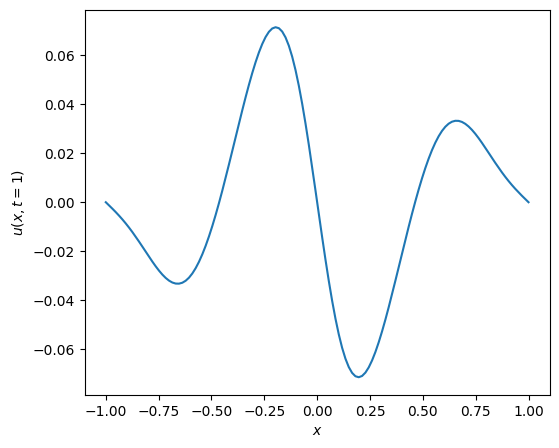

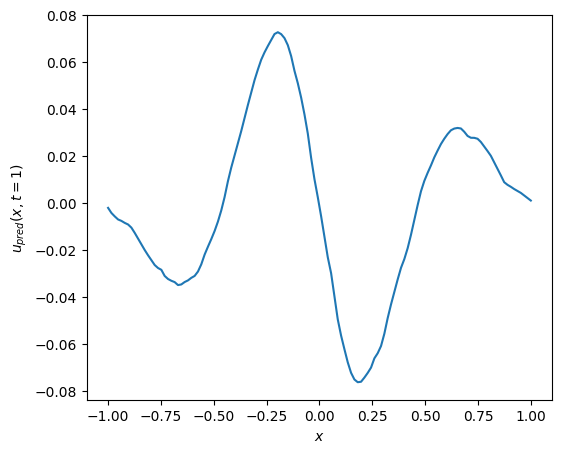

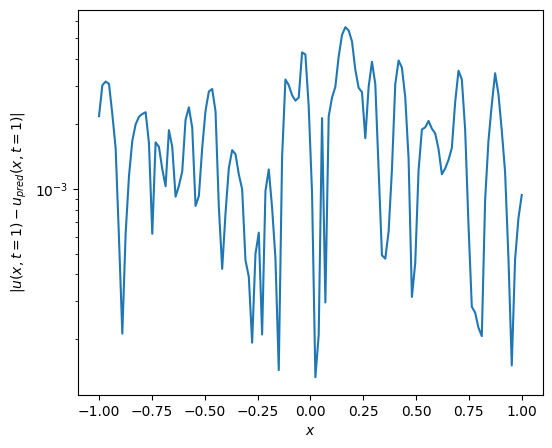

In [19]:
#First instances
axt_first = ax_t_test[0].to(device)
u_first = u_test[0].to(device)
u_first = u_first.permute(1, 0)

with torch.no_grad():

    axt_first = axt_first.unsqueeze(0)
    print(axt_first.shape)

    u_pred_first = model_u(axt_first)
    u_pred_first = u_pred_first.squeeze(0).squeeze(-1)
    print(u_pred_first.shape)
    print(u_first.shape)

    # Plot and save the initial true field
    fig0, ax0 = plt.subplots(figsize=(6, 5))
    ax0.plot(x_mesh.cpu().numpy().flatten(), a_test[0, :, 0, 0].cpu().numpy())
    ax0.set_xlabel(r"$x$")
    ax0.set_ylabel(r"$u(x, t=0)$")
    plt.savefig("task4_true_t0.pdf")

    fig_pred_t0, ax_pred_t0 = plt.subplots(figsize=(6, 5))
    ax_pred_t0.plot(x_mesh.cpu().numpy().flatten(), a_test[0, :, 0, 0].cpu().numpy())
    ax_pred_t0.set_xlabel(r"$x$")
    ax_pred_t0.set_ylabel(r"$u_{pred}(x, t=0)$")
    plt.savefig("task4_pred_t0.pdf")
    plt.close(fig_pred_t0)

    fig1, ax1 = plt.subplots(figsize=(6, 5))
    ax1.plot(x_mesh.cpu().numpy().flatten(), u_first[:, -1].cpu().numpy())
    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$u(x, t=1)$")
    plt.savefig("task4_true_tf.pdf")

    fig2, ax2 = plt.subplots(figsize=(6, 5))
    ax2.plot(x_mesh.cpu().numpy().flatten(), u_pred_first[:, -1].cpu().numpy())
    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$u_{pred}(x, t=1)$")
    plt.savefig("task4_pred_tf.pdf")

    fig3, ax3 = plt.subplots(figsize=(6, 5))
    ax3.semilogy(x_mesh.cpu().numpy().flatten(), torch.abs(u_first[:, -1].cpu() - u_pred_first[:, -1].cpu()).numpy())
    ax3.set_xlabel(r"$x$")
    ax3.set_ylabel(r"$|u(x, t=1) - u_{pred}(x, t=1)|$")
    plt.savefig("task4_error_tf.pdf")

    first_test_error = error_fn(ax_t_test[0].unsqueeze(0), u_test_plot[0].unsqueeze(0))
    print(f"L2 Relative Error for the first test sample: {first_test_error.item():.6f}")

    fig_error, ax_error = plt.subplots(figsize=(6, 5))
    ax_error.semilogy(error_history)
    ax_error.set_xlabel("epoch")
    ax_error.set_ylabel("error")
    plt.savefig("task4_error_history.pdf")
    plt.close(fig_error)